Encoding primitive sequences w/ PrimitiveAE

In [1]:
%load_ext autoreload
%autoreload 2

import os
import json
from copy import deepcopy
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
import torch

from sketchgraphs.data import flat_array
import sketchgraphs.data as datalib

import img2cad.data_utils as i2c_utils
from img2cad.prerender_images import _render_and_save
from img2cad import dataset
import img2cad.modules as modules
from img2cad.train_primitives import device

In [2]:
model_path = '../output/0324/time_150213/model_1_20000_0.257.pt'  # PrimitiveAE
# model_path = '../output/0106/time_193946/model_9_30000_0.620.pt'  # ImageToPrimitiveModel

with open(os.path.join(os.path.dirname(model_path), 'args.txt'), 'r') as file_:
    config = json.load(file_)
model = modules.PrimitiveAE(config['encode_dim'], config['num_bins'], config['max_entities'],
                            config['embed_dim'], config['fc_size'], config['num_heads'],
                            config['num_layers'])
# model = modules.ImageToPrimitiveModel(config['num_bins'], config['max_entities'],
#                                       config['embed_dim'], config['fc_size'], config['num_heads'],
#                                       config['num_layers'])
model.load_state_dict(torch.load(model_path))
# model = torch.load(model_path)
model.eval()
model = model.to(device)

In [3]:
# Load dataset
use_images = isinstance(model, modules.ImageToPrimitiveModel)
dset = dataset.PrimitiveDataset(config['seq_file'],
                                config['img_dir'],
                                config['num_bins'],
                                config['max_token_len'],
                                use_images=use_images)

In [4]:
max_idx = 1000
seqs = [dset.get_seq(idx) for idx in range(max_idx)]
sketches = [datalib.sketch_from_sequence(seq) for seq in tqdm(seqs)]

100%|██████████| 1000/1000 [00:00<00:00, 3767.76it/s]


In [5]:
encodings = []

# Encode sequences
for idx, (seq, sketch) in tqdm(enumerate(zip(seqs[:max_idx], sketches[:max_idx])), total=max_idx):
    tok_input = dset.tokenize_seq(seq)
    if dset.use_images:
        tok_input['img'] = dset.get_image(idx)
    for tok_type, tokens in tok_input.items():
        if not isinstance(tokens, torch.Tensor):
            tokens = torch.tensor(tokens)
        tok_input[tok_type] = tokens[None, ...].to(device)
    encoding = model.encode(tok_input).cpu().detach().numpy().squeeze()
    encodings.append(encoding)

100%|██████████| 1000/1000 [00:10<00:00, 94.41it/s]


In [6]:
# t-SNE
from sklearn.manifold import TSNE

X = np.stack(encodings)
X_embedded = TSNE(n_components=2, perplexity=50).fit_transform(X)

100%|██████████| 1000/1000 [00:43<00:00, 22.91it/s]


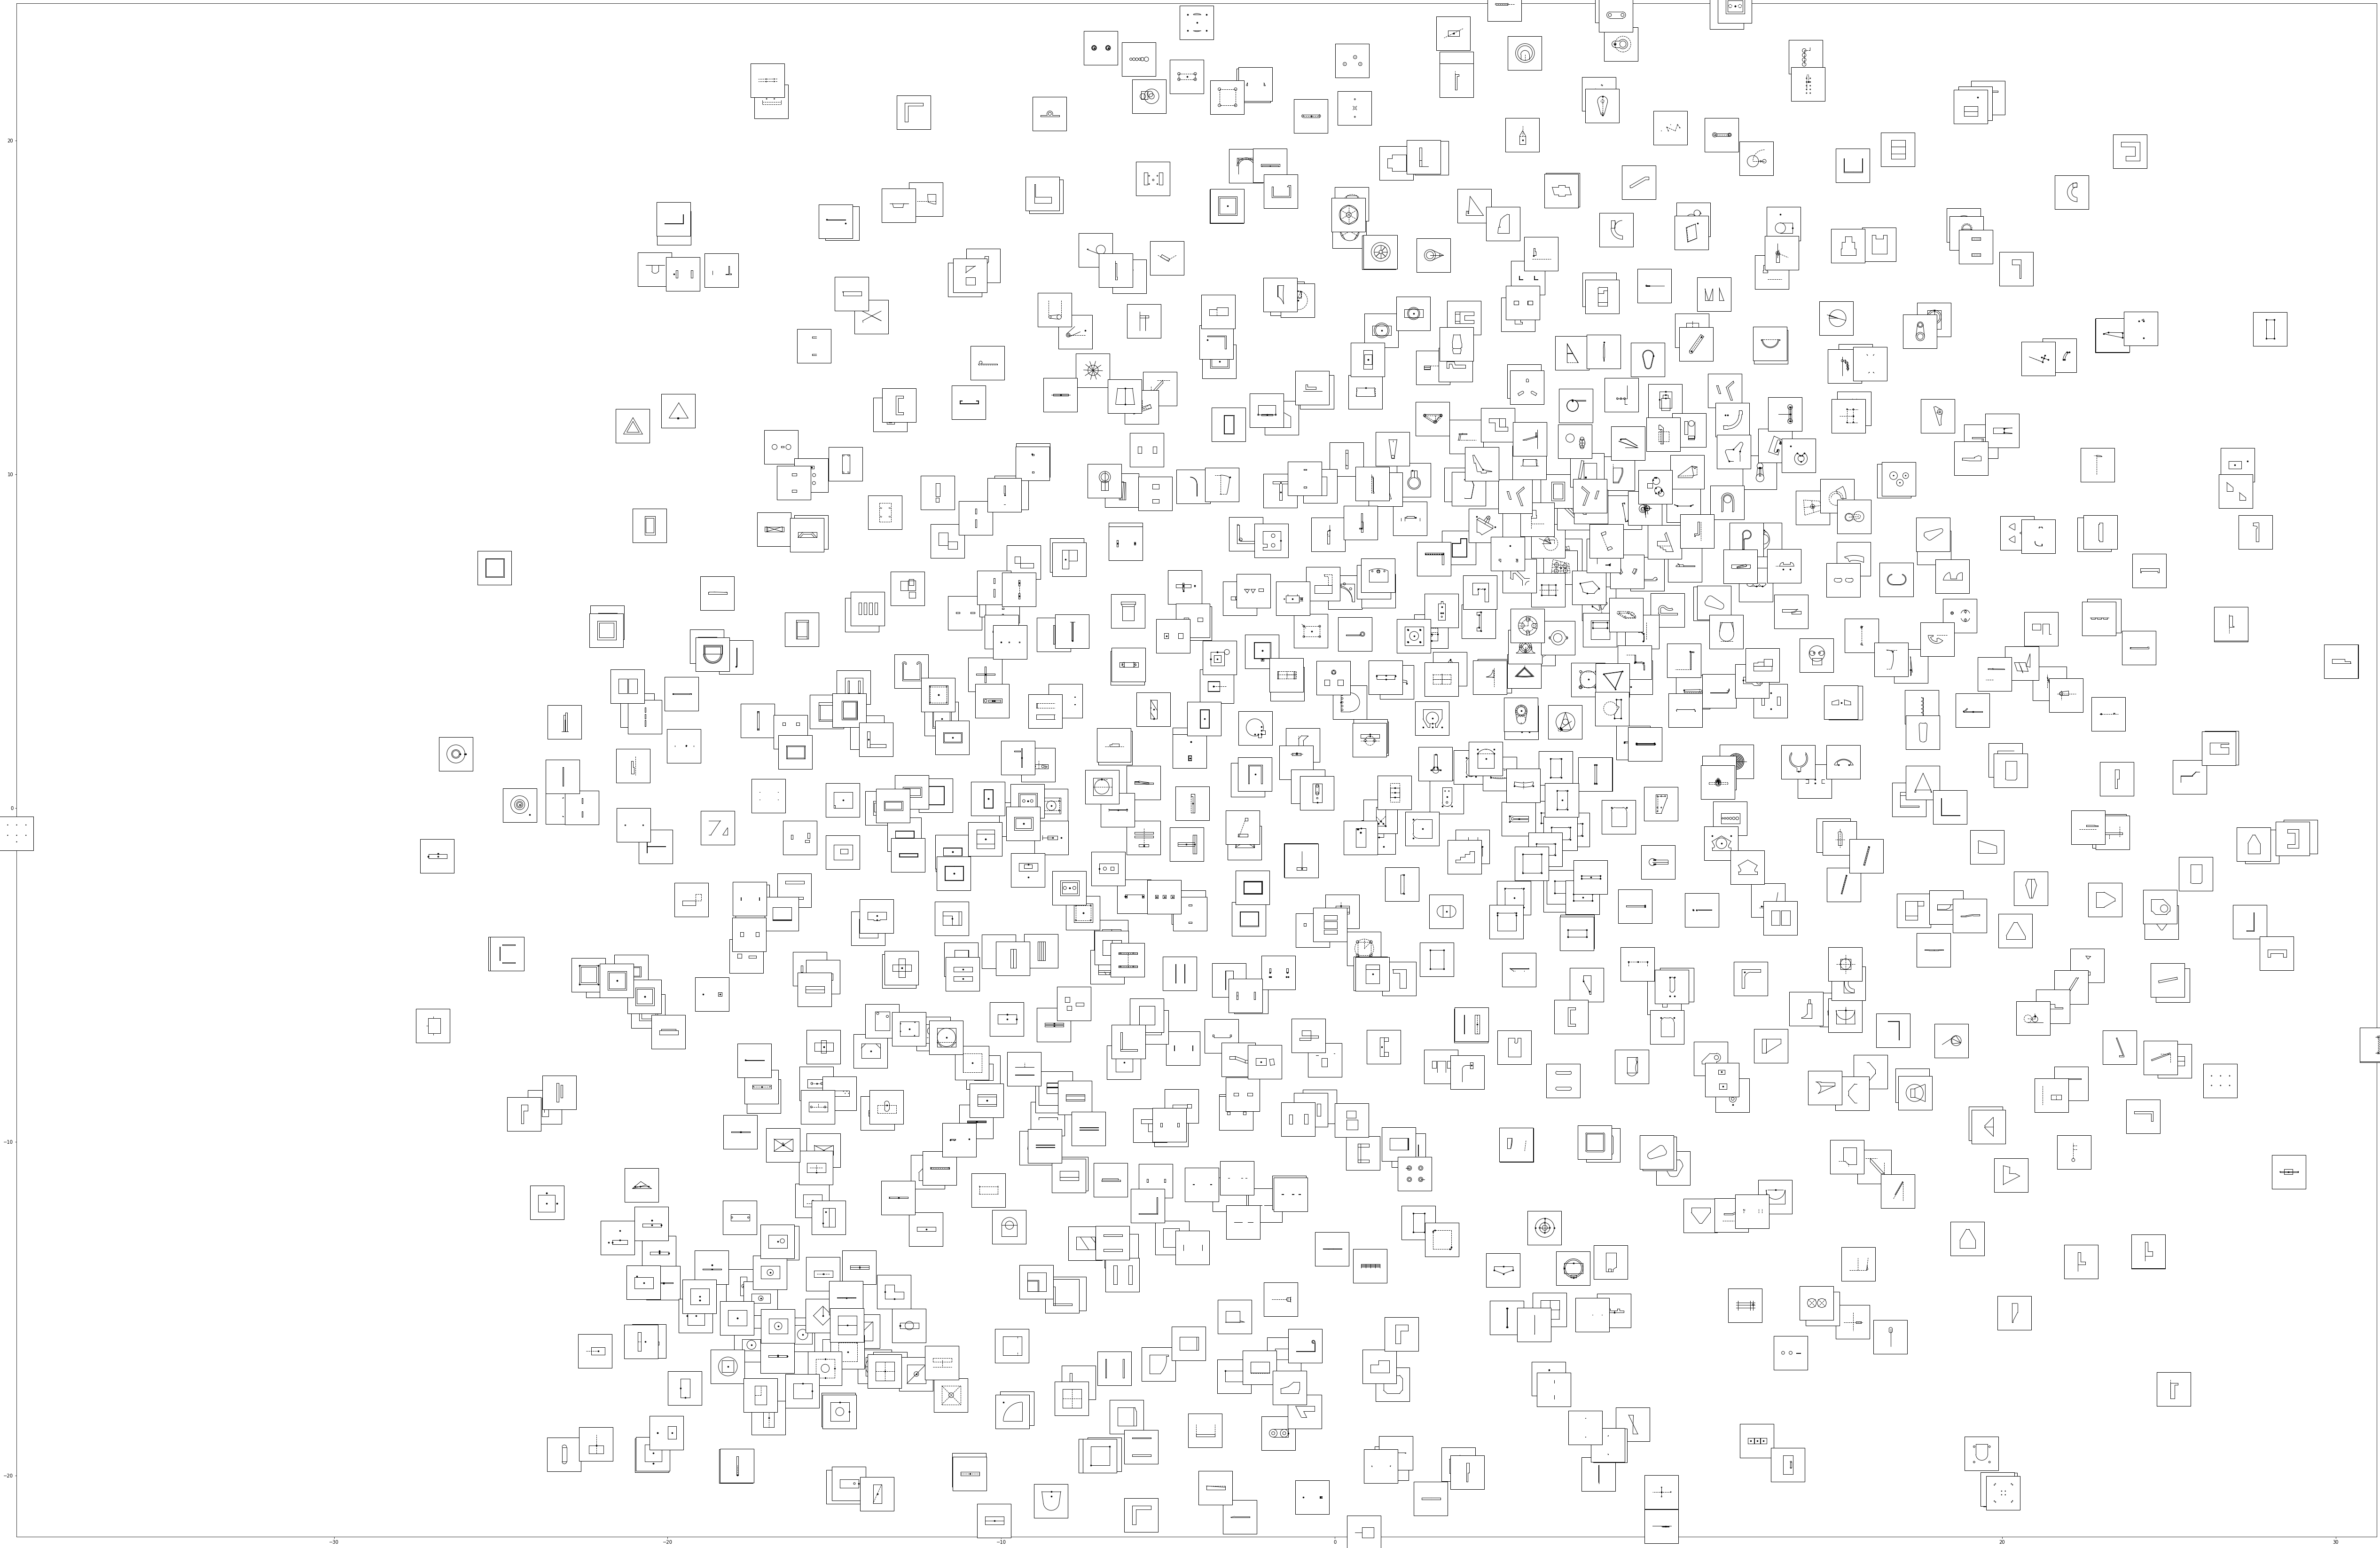

In [7]:
# Render images according to 2D embeddings

from matplotlib.offsetbox import OffsetImage, AnnotationBbox

def getImage(sketch):
    i2c_utils.normalize_sketch(sketch)
    _render_and_save(sketch, 'tmp.png')
    return OffsetImage(plt.imread('tmp.png'))

fig, ax = plt.subplots()
ax.axis('equal')

for sketch_idx in tqdm(range(max_idx)):
    sketch = sketches[sketch_idx]
    x0, y0 = X_embedded[sketch_idx]
    ab = AnnotationBbox(getImage(sketch), (x0, y0), frameon=True)
    ax.add_artist(ab)
    
ax.set_xlim(min(X_embedded[:,0]), max(X_embedded[:,0]))
ax.set_ylim(min(X_embedded[:,1]), max(X_embedded[:,1]))

w, h = fig.get_size_inches()
fig.set_size_inches(w * 15, h * 15)